## Mortgage Data
Annabella Stoll-Dansereau

 For a comprehensive report please see the pdf file. Much of this notebook isn't run because I ran it once and saved everything as csv files due to computational overhead. The more managable csv's created by the importing and matching are attached for convience. 

#### Data Source 
In this section I read in all the mortgage data for select counties in California, Arizona, and Nevada derived from Querying a series of microsoft access databases. This data was sourced from FHMA and we are using 2012-2019 (since the data format changes post 2019 and I was worried about the consistency). 

#### Description of the following code 

These imports include Sacramento, Fresno, Las Vegas, Reno, Tuscan, and Phoenix as these seemed like the most similar cities in Arizona. Using cost of living comparison calculator by https://www.forbes.com/advisor/mortgages/real-estate/cost-of-living-calculator I created a dictionary maping what would be equivalent amounts to 98,500. My covariates here are low income mortgage counts, income tract ratio (median income in this tract / tract area median income), and percentage minority in this tract. Initially I wanted to add in census data for additional covariates such as home ownership rates however due to computing restrictions this didn't seem appropriate for this projects timeline.

The subseted data sets are provided, note the following code does work but if you run it on your own you may have to subset the data and then merge it later as it crashes midway through. 

In [33]:
import pandas as pd 

years = list(range(2012, 2020)) 

collapsed_df = None

# Thresholds dictionary
thresholds = {
    3: 98500, #Las Vegas county
    50: 107756, #Fresno county
    67: 119729, #Sacramento 
    31: 104637, #Reno
    19: 104336, #Tucson
    13: 103531, #Phoenix
    21: 103531 #Phoenix

}

# Function for counting low income mortgages
def count_low_income_mortgages(x, county_code):
    threshold = thresholds.get(county_code, 98500) # Default threshold
    return (x < threshold).sum()

for n, year in enumerate(years):
    df = pd.read_excel(rf"C:\Users\annab\OneDrive\Desktop\Year 4 fun stuff\526\morgage data\State County {year}.xlsx")

    if n == 0:
        # Initial year, establish the collapsed_df with additional data
        collapsed_df = df.groupby(['Census Tract - 2010 Census']).apply(
            lambda group: pd.Series({
                'US Postal State Code': group['US Postal State Code'].iloc[0],
                'County - 2010 Census': group['County - 2010 Census'].iloc[0],
                '2010 Census Tract - Percent Minority': group['2010 Census Tract - Percent Minority'].iloc[0],
                'Tract Income Ratio': group['Tract Income Ratio'].iloc[0] * 100,
                f'Num Low Income Mortgages {year}': count_low_income_mortgages(group['Borrower(s) Annual Income'], group['County - 2010 Census'].iloc[0])
            })
        ).reset_index()
        
    else:
        # Subsequent years, only get the count data
        temp_df = df.groupby(['Census Tract - 2010 Census']).apply(
            lambda group: pd.Series({
                f'Num Low Income Mortgages {year}': count_low_income_mortgages(group['Borrower(s) Annual Income'], group['County - 2010 Census'].iloc[0])
            })
        ).reset_index()

        # Merge with the existing collapsed_df
        collapsed_df = collapsed_df.merge(temp_df, on='Census Tract - 2010 Census', how='left')
        collapsed_df = collapsed_df.fillna(0)

    print(f'done {year}')
# Save to CSV
collapsed_df.to_csv(r'C:\Users\annab\OneDrive\Desktop\Year 4 fun stuff\526\morgage data\20122019_collapsed_mortgage_weighted.csv', index=False)


done 2012
done 2013
done 2014
done 2015
done 2016
done 2017


KeyError: 'County - 2010 Census'

#### Matching

Here I am creating the synthetic controls. Following the matching strategy used by "CITE TEXTBOOK" I created a synthetical control based on my covariates from 2012 to 2017. To slightly speed up the algorythim instead of starting at uniform weights I had it start at the weights found for the first iteration. This is from the guess that many of the treated tracts in Las Vegas are of similar low income, higher minority status than the uniform distribution over a city as such it will slightly speed up the optimizing process. Additionally I am only using Fresno and Tuscan due to computational limitations. 

In [17]:
import pandas as pd 
from scipy.optimize import fmin_slsqp
from toolz import partial
import numpy as np 
import matplotlib.pyplot as plt

collapsed_df = pd.read_csv(r'C:\Users\annab\OneDrive\Desktop\Year 4 fun stuff\526\morgage data\20122019_collapsed_mortgage.csv')

#this was a crosswalk dataframe from zipcodes to census tracts found by merging IMPUS GIS data then saving the overlapping regions as a csv
#some regions that have parts in the zip code and parts outside of the zip code were considered 'treated' even though not everyone in this region may recieve this treatment
crosswalk = pd.read_csv(r"C:\Users\annab\OneDrive\Desktop\Year 4 fun stuff\526\morgage data\filtered_zip_tract.csv")
crosswalk.columns = crosswalk.columns.str.lstrip('0') #changing codes from '06' -> '6'

#loss function we are minimizing
def loss_w(W, X, y) -> float:
    return np.sqrt(np.mean((y - X.dot(W))**2))

#function to get the weights
def get_w(X, y, initial_weights=None):
    if initial_weights is None:
        initial_weights = [1/X.shape[1]] * X.shape[1]
    
    weights = fmin_slsqp(partial(loss_w, X=X, y=y),
                         np.array(initial_weights),
                         f_eqcons=lambda x: np.sum(x) - 1,
                         bounds=[(0.0, 1.0)] * len(initial_weights),
                         disp=False)
    return weights


control_pool = collapsed_df[(collapsed_df['County - 2010 Census'] == 19) | (collapsed_df['County - 2010 Census'] == 50)].drop(columns=['US Postal State Code', 'County - 2010 Census']) 
treated = collapsed_df[collapsed_df['Census Tract - 2010 Census'].isin(crosswalk['TRACTCE'])]
treated = treated[treated['County - 2010 Census'] == 3].drop(columns=['US Postal State Code', 'County - 2010 Census']) #some overlap between county and codes so make sure its the correct filter
print("Length of treated:", len(treated))
print("Length of control_pool:", len(control_pool))


treated = treated.melt(id_vars=['Census Tract - 2010 Census'], var_name='variable', value_name='value')
treated = treated.pivot(index='variable', columns='Census Tract - 2010 Census', values='value')
control_pool = control_pool.melt(id_vars=['Census Tract - 2010 Census'], var_name='variable', value_name='value')
control_pool = control_pool.pivot(index='variable', columns='Census Tract - 2010 Census', values='value')
#control_pool=control_pool.iloc[:, :10] for if you want to test and have it work in finite time
synthetic_controls = {}

#dont want to train on what we want to predict after the policy occurs
rows_to_keep = ~treated.index.str.contains('2018|2019')
treated_dropped = treated[rows_to_keep]
control_dropped = control_pool[rows_to_keep]
synthetic_controls_df = pd.DataFrame()

first_iteration = True
stored_weights = None

#for n, column in enumerate(treated.columns):
for n, column in enumerate(treated_dropped.columns[:2]):
    print(n)
    y = treated_dropped[column].values  # Treated unit's values
    X = control_dropped.values          # Control units' values
    #slightly faster to start here rather than uniform
    if first_iteration:
        weights = get_w(X, y)
        stored_weights = weights
        first_iteration = False
    else:
        weights = get_w(X, y, initial_weights=stored_weights)

    synthetic_control = control_pool.dot(weights)
    # Store the synthetic control series in the dictionary more efficient than df
    synthetic_controls[f'syn_{column}'] = synthetic_control
synthetic_controls_df = pd.DataFrame(synthetic_controls)
treated = pd.concat([treated, synthetic_controls_df], axis=1)

#save as a treated csv to use later, again since this process takes so long to run
#treated.to_csv(r'C:\Users\annab\OneDrive\Desktop\Year 4 fun stuff\526\morgage data\treated_dataframe.csv', index=True)

Length of treated: 236
Length of control_pool: 335
0
1


#### Cleaning the dataframe to be in a Diff-in-Diff format

In [35]:
# Read out treated df from above since it takes forever to run
treated = pd.read_csv(r'C:\Users\annab\OneDrive\Desktop\Year 4 fun stuff\526\morgage data\treated_dataframe.csv')
#this is getting rid of the Tract Income Ratio which is the last column and 2010 Census Tract - Percent Minority which is first
treated = treated.drop([0, len(treated)-1]) 
#get a list of all the treated tracts
tracts = treated.columns[:len(treated.columns)//2].tolist()
all_tracts_long_df = pd.DataFrame()

# Loop over each tract to transpose and melt the data into a format we can run the DiD on
for tract in tracts:
    col_df = treated[[tract, f'syn_{tract}']].transpose()
    
    # Rename the columns to years observed
    new_column_names = {i: year for i, year in enumerate(range(2012, 2012 + len(col_df.columns)), start=1)}
    col_df = col_df.rename(columns=new_column_names)
    long_df = col_df.reset_index().melt(id_vars='index', var_name='Year', value_name='Value')
    
    long_df = long_df.rename(columns={'index': 'Group'})
    long_df['Tract'] = tract  # keep track of the tract
    # Append to the all_tracts_long_df DataFrame
    all_tracts_long_df = pd.concat([all_tracts_long_df, long_df], ignore_index=True)

all_tracts_long_df['Year'] = all_tracts_long_df['Year'].astype(int)
# Create 'treated' and 'post' columns
all_tracts_long_df['treated'] = all_tracts_long_df['Group'].apply(lambda x: 1 if 'syn' not in x else 0)
all_tracts_long_df['post'] = all_tracts_long_df['Year'].apply(lambda x: 1 if x >= 2018 else 0)

,Group,Year,Value,Tract,treated,post
0,101,2012,60.000000,101,1,0
1,syn_101,2012,60.021288,101,0,0
2,101,2013,72.000000,101,1,0
3,syn_101,2013,71.924966,101,0,0
4,101,2014,37.000000,101,1,0
...,...,...,...,...,...,...
3771,syn_7200,2017,46.000376,7200,0,0
3772,7200,2018,47.000000,7200,1,1
3773,syn_7200,2018,40.621363,7200,0,1
3774,7200,2019,45.000000,7200,1,1


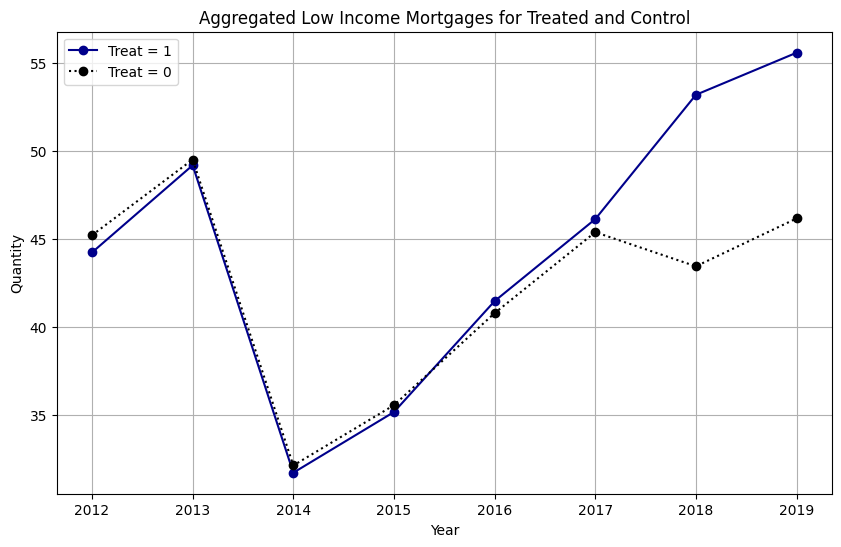

In [58]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
colors = ['darkblue', 'black']  # Specify the colors for each line
line = ['-',':']
for i, treat in enumerate([1, 0]):
    subset = all_tracts_long_df[all_tracts_long_df['treated'] == treat]
    plt.plot(subset['Year'].unique(), subset.groupby('Year')['Value'].mean(), marker='o', label=f'Treat = {treat}', linestyle =line[i],  color=colors[i])

plt.xlabel('Year')
plt.ylabel('Quantity')
plt.title('Aggregated Low Income Mortgages for Treated and Control')
plt.legend()
plt.grid(True)
plt.show()

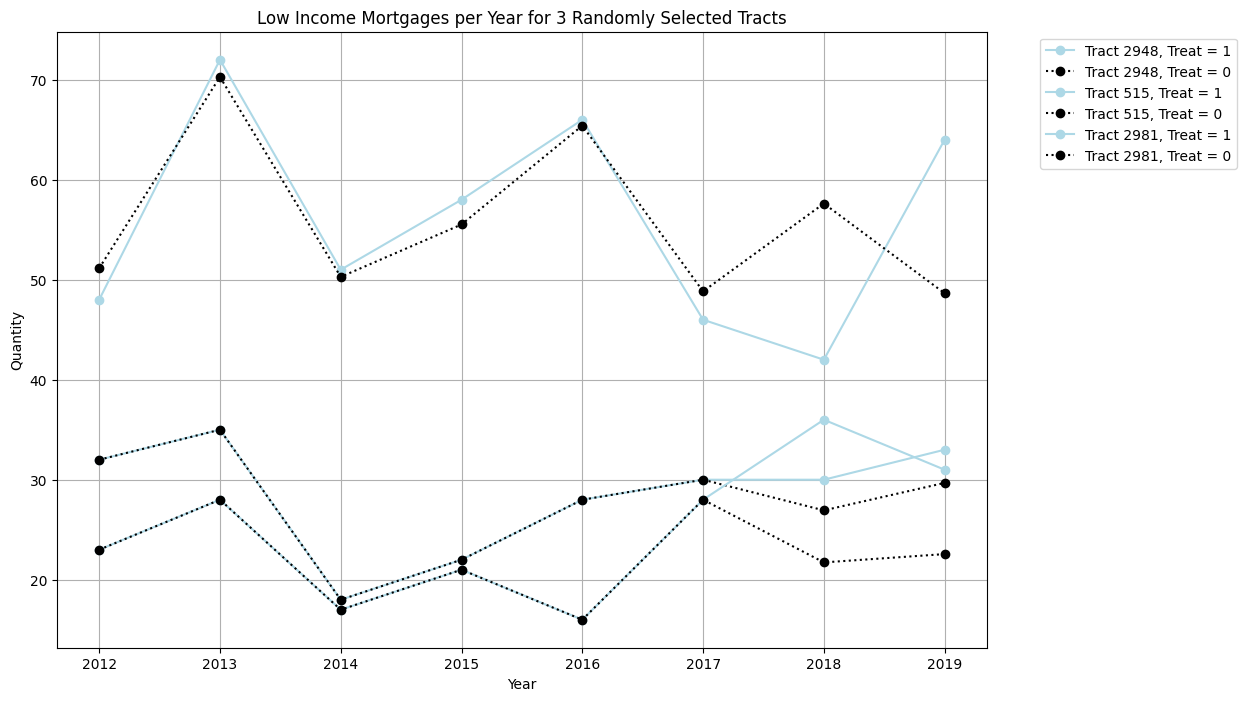

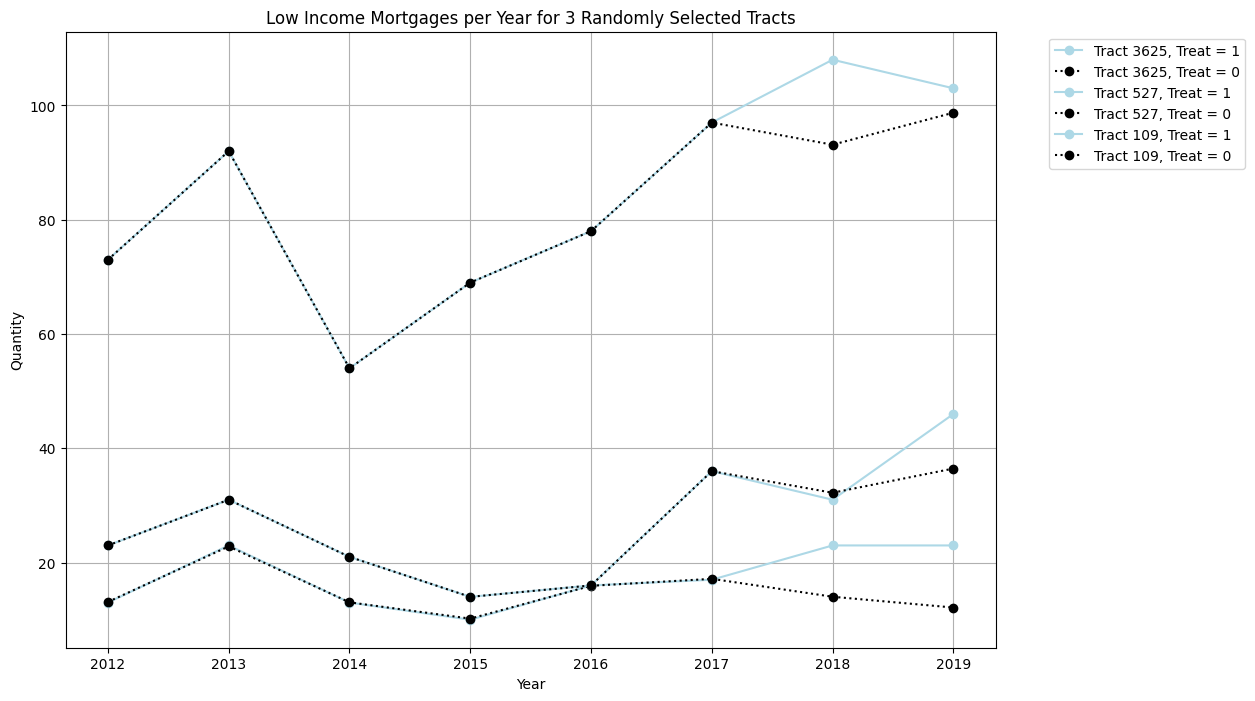

In [56]:
import random
random.seed(47)

# Generate random tracts
random_tracts = random.sample(tracts, 3)

# Initialize plot
plt.figure(figsize=(12, 8))

# Plot for each tract
for tract in random_tracts:
    # Filter data for each tract and treatment type
    tract_data_treat_1 = all_tracts_long_df[(all_tracts_long_df['Tract'] == tract) & (all_tracts_long_df['treated'] == 1)]
    tract_data_treat_0 = all_tracts_long_df[(all_tracts_long_df['Tract'] == tract) & (all_tracts_long_df['treated'] == 0)]

    # Sort by year to make line plot correct
    tract_data_treat_1 = tract_data_treat_1.sort_values('Year')
    tract_data_treat_0 = tract_data_treat_0.sort_values('Year')

    # Plot lines for treat = 1 in light blue
    plt.plot(tract_data_treat_1['Year'], tract_data_treat_1['Value'], color='lightblue',  marker='o', label=f'Tract {tract}, Treat = 1')
    
    # Plot lines for treat = 0 in dotted black
    plt.plot(tract_data_treat_0['Year'], tract_data_treat_0['Value'], color='black', linestyle=':', marker='o', label=f'Tract {tract}, Treat = 0')

# Set plot features
plt.xlabel('Year')
plt.ylabel('Quantity')
plt.title('Low Income Mortgages per Year for 3 Randomly Selected Tracts')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()
import random
random.seed(42)

# Generate random tracts
random_tracts = random.sample(tracts, 3)

# Initialize plot
plt.figure(figsize=(12, 8))

# Plot for each tract
for tract in random_tracts:
    # Filter data for each tract and treatment type
    tract_data_treat_1 = all_tracts_long_df[(all_tracts_long_df['Tract'] == tract) & (all_tracts_long_df['treated'] == 1)]
    tract_data_treat_0 = all_tracts_long_df[(all_tracts_long_df['Tract'] == tract) & (all_tracts_long_df['treated'] == 0)]

    # Sort by year to make line plot correct
    tract_data_treat_1 = tract_data_treat_1.sort_values('Year')
    tract_data_treat_0 = tract_data_treat_0.sort_values('Year')

    # Plot lines for treat = 1 in light blue
    plt.plot(tract_data_treat_1['Year'], tract_data_treat_1['Value'], color='lightblue',  marker='o', label=f'Tract {tract}, Treat = 1')
    
    # Plot lines for treat = 0 in dotted black
    plt.plot(tract_data_treat_0['Year'], tract_data_treat_0['Value'], color='black', linestyle=':', marker='o', label=f'Tract {tract}, Treat = 0')

# Set plot features
plt.xlabel('Year')
plt.ylabel('Quantity')
plt.title('Low Income Mortgages per Year for 3 Randomly Selected Tracts')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()

## Diff and Diff 

Here I am doing inference on the matched groups. We are controling for the census tract as that is what we matched on and running many sub diff and diff's essentially. The treated:post interaction term at the bottom of my regression output shows us the overall impact this policy had on mortgage rates on low income indivisuals in Las Vegas relative to our synthetic controls we derived. 

In [68]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
import io 

# Fit the DiD model with 'Tract' as a fixed effect
did_formula = 'Value ~ treated + post + treated:post + C(Tract)'
did_model = smf.ols(formula=did_formula, data=all_tracts_long_df).fit() 
#print(did_model.summary()) #summary is just a ton of fixed effects but here is the output on the interaction term
html_table = did_model.summary().tables[1].as_html()
summary_df = pd.read_html(io.StringIO(html_table), header=0, index_col=0)[0]
row = summary_df.loc['treated:post']
print(row)


coef        9.7065
std err     0.9930
t           9.7790
P>|t|       0.0000
[0.025      7.7600
0.975]     11.6530
Name: treated:post, dtype: float64
